In [1]:
#SAM stuff
from fastsam import FastSAM, FastSAMPrompt
import cv2
import numpy as np

#CLIP Stuff
from PIL import Image
import io
import torch
import clip

#image display stuff
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# Example on a Single Image

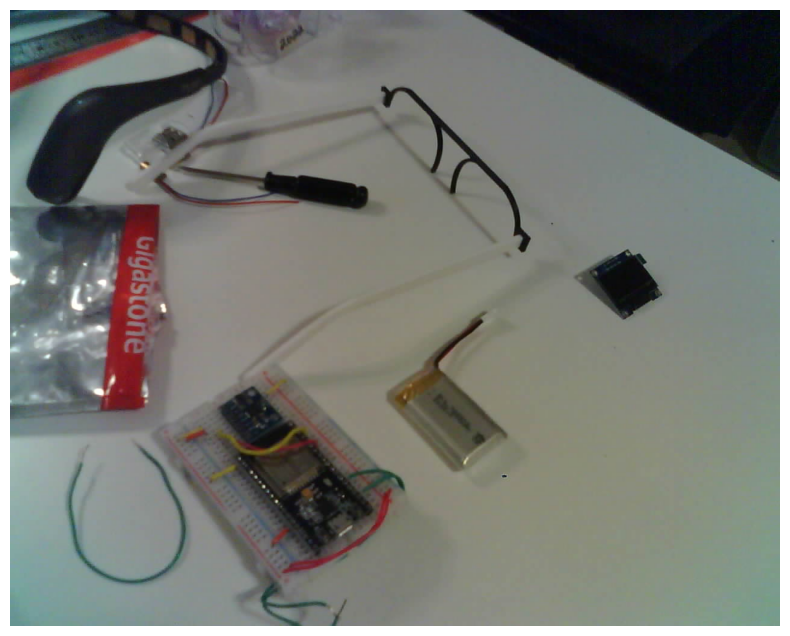

In [3]:
TEXT_DESCRIPTION = "black glasses frames"
THRESHOLD = 0.28

IMAGE_PATH = "Pictures/7.jpg"
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

img_dict = {
    "vector": [],
    "boundary": [],
    "similarity": [],
}

plt.figure(figsize=(16, 8))
plt.axis('off')
plt.imshow(Image.open(IMAGE_PATH))

## Segment the image with SAM


image 1/1 c:\Users\xande\Dropbox\1 - Projects\240000-CODING-PROJECTS\Semantic-Search-with-SAM\Pictures\7.jpg: 320x384 18 objects, 650.1ms
Speed: 5.5ms preprocess, 650.1ms inference, 201.0ms postprocess per image at shape (1, 3, 320, 384)


18


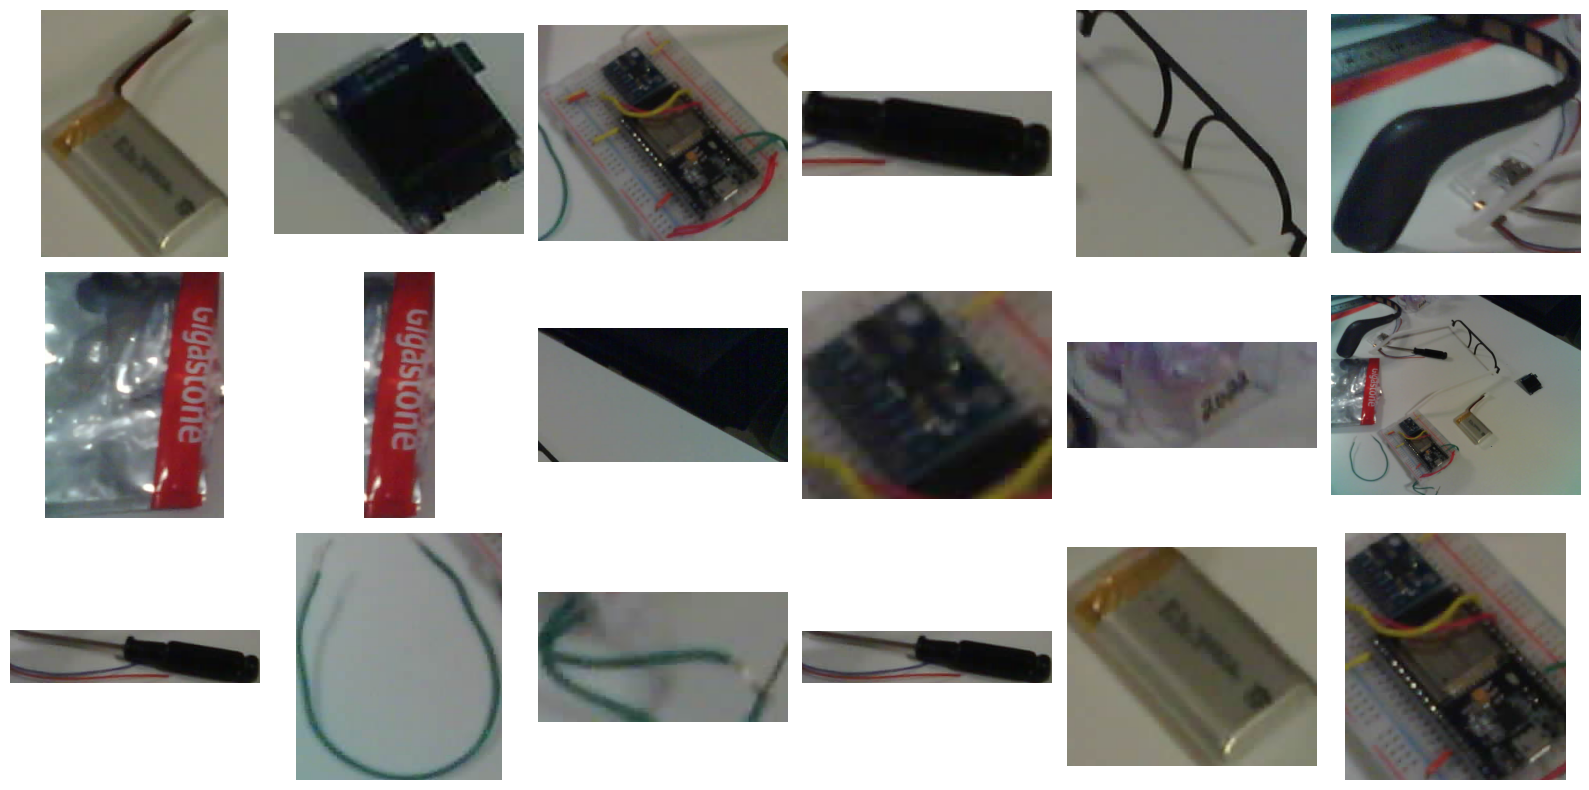

In [4]:
modelSAM = FastSAM('FastSAM-x.pt')

everything_results = modelSAM(IMAGE_PATH, device=device, retina_masks=True, imgsz=384, conf=0.3, iou=0.9,)
prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=device)

# everything prompt
prompt_process.everything_prompt()

num_of_masks = len(everything_results[0])
print(num_of_masks)

#display images with matplotlib
fig, axes = plt.subplots(nrows=int(np.ceil(num_of_masks/6)), ncols=6, figsize=(16, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for index, r in enumerate(everything_results[0]):
    maskCoords = (r.masks.xy)[0]

    xy_array = np.array(maskCoords)
    contour = xy_array.reshape((-1, 1, 2)).astype(np.int32)

    x, y, w, h = cv2.boundingRect(contour)
    img_dict['boundary'].append((x, y, w, h))
    
    ax = axes[index]
    result_image = image[y:y+h, x:x+w]
    ax.axis('off')
    ax.imshow(result_image)

plt.tight_layout()
plt.show()

## Generate embeddings for the segmented images with CLIP

In [5]:
modelCLIP, preprocess = clip.load("ViT-B/32", device=device)

for b in img_dict['boundary']:
    result_image = image[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]    #b[0] = x (left), b[1] = y (top), b[2] = width, b[3] = height
    result_image = preprocess(Image.fromarray(result_image)).unsqueeze(0).to(device)
    image_features = modelCLIP.encode_image(result_image)
    img_dict["vector"].append(image_features[0])

## Cosine Similarity

In [6]:
def cosineSimilarity(a, b):
    dotProduct = torch.dot(a, b).cpu().item()
    return (dotProduct)/(torch.norm(a).cpu().item()*torch.norm(b).cpu().item())

text = clip.tokenize(TEXT_DESCRIPTION).to(device)
text_features = modelCLIP.encode_text(text)[0]

img_dict["similarity"] = []
for v in img_dict['vector']:
    img_dict['similarity'].append(cosineSimilarity(text_features, v))

img_dict['similarity']

[0.2255673417542664,
 0.21963975742011074,
 0.16981219187852192,
 0.24514705266006603,
 0.31153906296831985,
 0.24667420532916612,
 0.22344775466006048,
 0.21355012553483138,
 0.24085483523945625,
 0.2271762122375805,
 0.24300790429211064,
 0.21552172383899648,
 0.22367445684496107,
 0.23616546078989534,
 0.24179579299345294,
 0.22180574102721115,
 0.21566328837943338,
 0.17417752302339337]

## Display final image with boundaries of objects

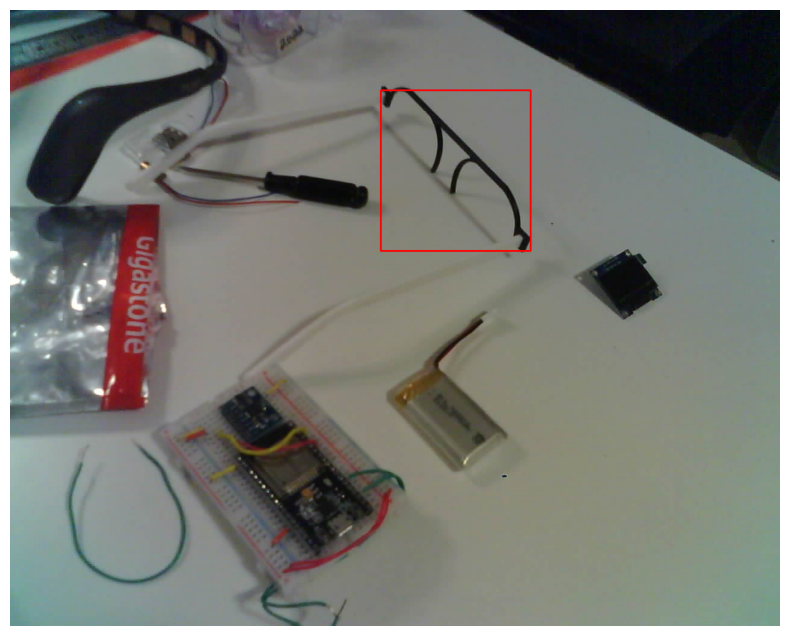

In [7]:
final_image = image
for index, s in enumerate(img_dict['similarity']):
    if(s > THRESHOLD):
        b = img_dict["boundary"][index]
        final_image = cv2.rectangle(image, (b[0], b[1]), (b[0]+b[2], b[1]+b[3]), (255, 0, 0), 2)

plt.figure(figsize=(16, 8))
plt.axis('off')
plt.imshow(final_image)